In [2]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

print(tf.__version__)

2.9.1


In [5]:
train_path='C:\\Users\\karak\\Downloads\\archive\\Train_Alphabet\\'
test_path= 'C:\\Users\\karak\\Downloads\\archive\\Test_Alphabet\\'
for d in [train_path, test_path]:
    filepaths = []
    labels=[]
    classlist=sorted(os.listdir(d))
    for klass in classlist:        
        classpath=os.path.join(d, klass)
        flist=sorted(os.listdir(classpath))
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')        
    if d == train_path:            
        df=pd.concat([Fseries, Lseries], axis=1)
    else:
        test_df=pd.concat([Fseries, Lseries], axis=1)
train_df, valid_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels']) 
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# get the number of classes and the images count for each class in train_df
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))

# get the classes with the minimum and maximum number of train images
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)
# lets get the average height and width of a sample of the train images
ht=0
wt=0
# select 100 random samples of train_df
train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

train_df lenght:  21870   test_df length:  2700   valid_df length:  2430
The number of classes in the dataset is:  27
            CLASS               IMAGE COUNT 
              A                     810     
              B                     810     
            Blank                   810     
              C                     810     
              D                     810     
              E                     810     
              F                     810     
              G                     810     
              H                     810     
              I                     810     
              J                     810     
              K                     810     
              L                     810     
              M                     810     
              N                     810     
              O                     810     
              P                     810     
              Q                     810     
              R            

In [6]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df

max_samples=150 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=150
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  150  and the minimum samples in any class is  150


In [7]:
working_dir=r'./'
img_size=(200,200)
batch_size=30 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 4050 validated image filenames belonging to 27 classes.          for train generator 
Found 2430 validated image filenames belonging to 27 classes.          for valid generator 
Found 2700 validated image filenames belonging to 27 classes.          for test generator 
test batch size:  75   test steps:  36  number of classes :  27


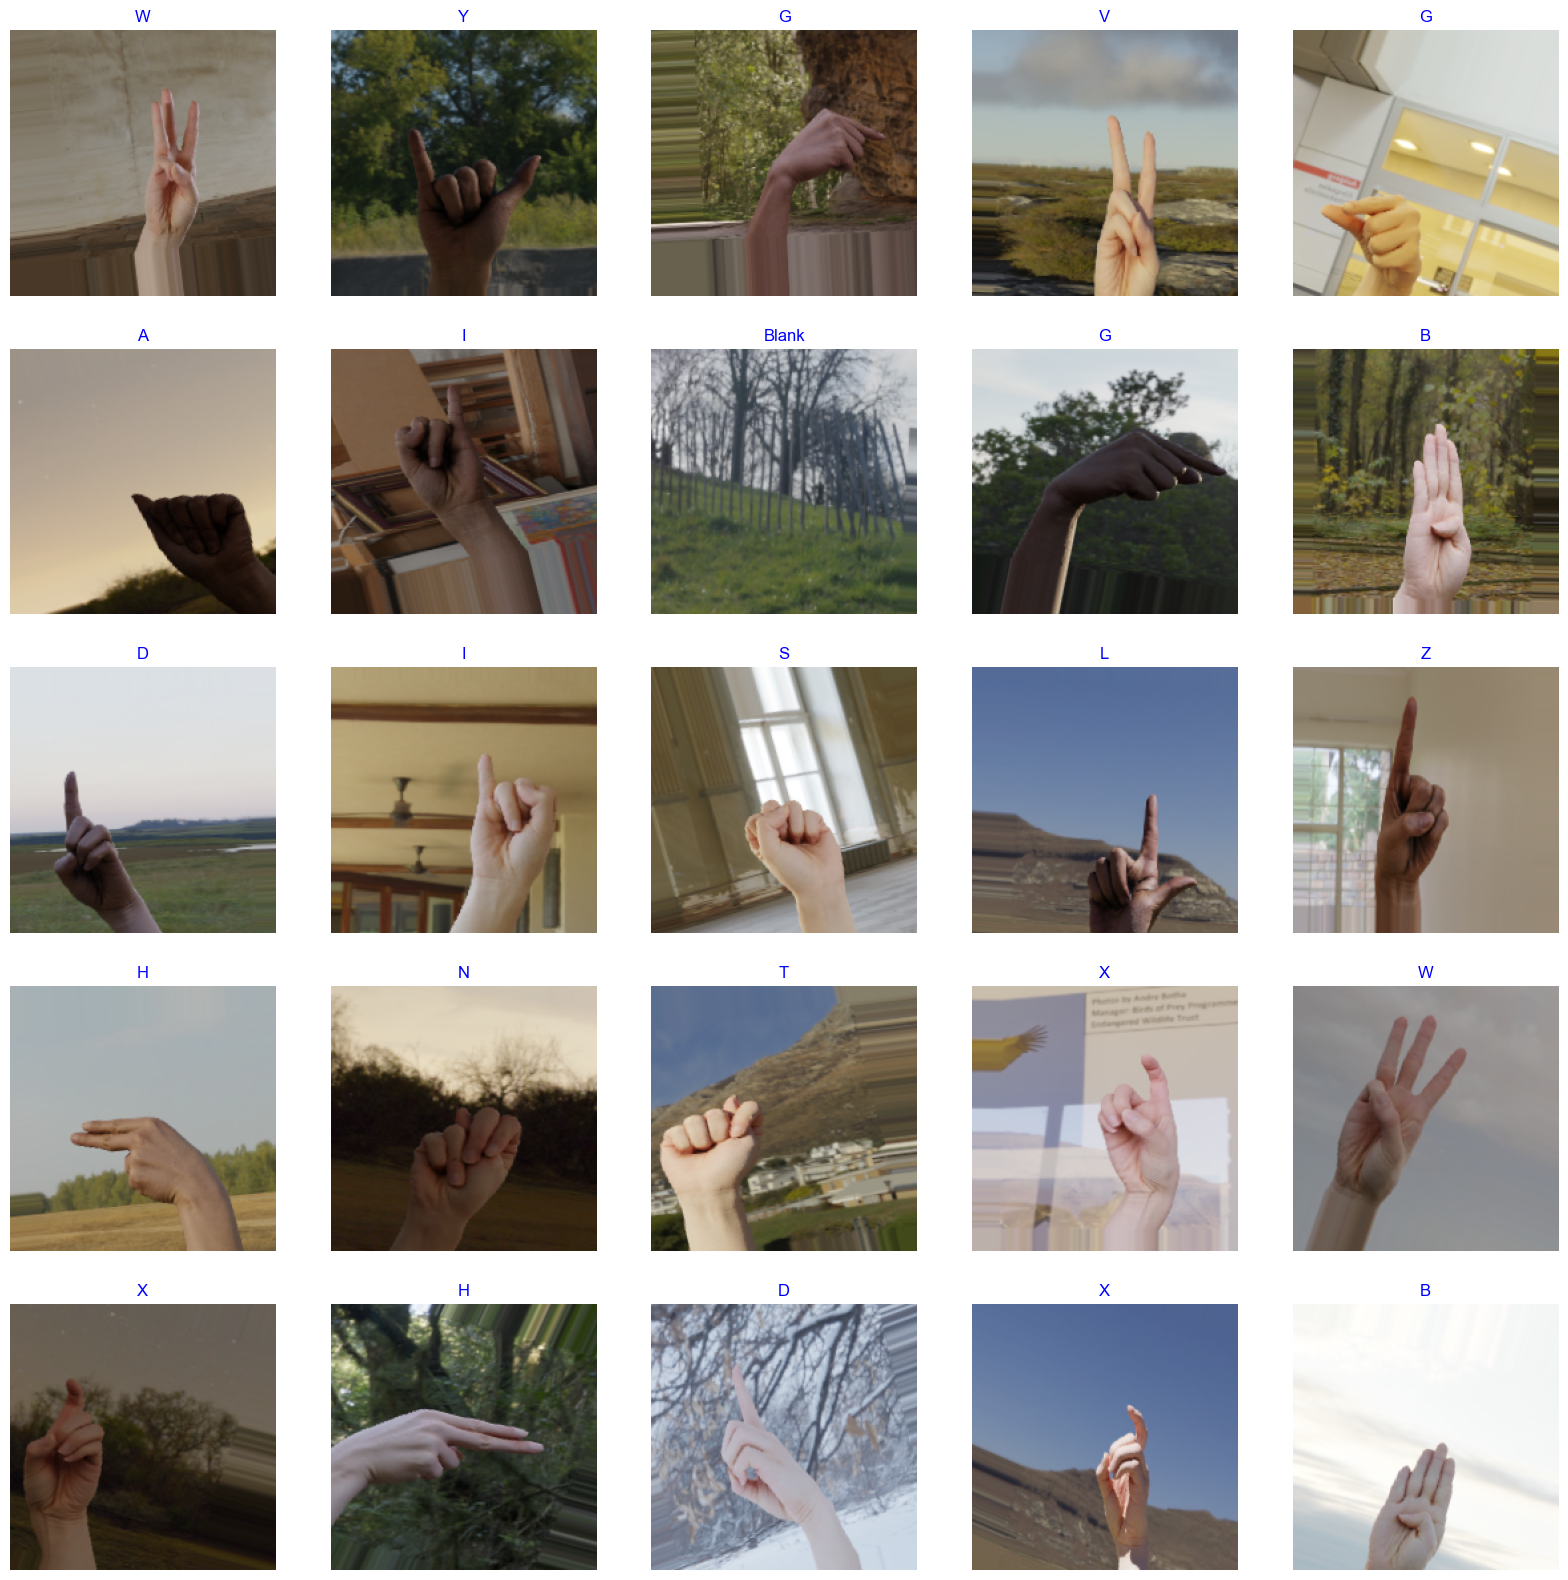

In [8]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

In [9]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.005 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43941136/43941136 [==============================] - 4s 0us/step


In [10]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print ('\n validation loss reduced, saving weights from epoch ', epoch + 1, ' as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print('current LR is ', lr,'  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print ('keeping current LR')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [11]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

In [12]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
135/135 [==============================] - ETA: 0s - loss: 7.9946 - accuracy: 0.4560
 validation loss reduced, saving weights from epoch  1  as best weights
135/135 [==============================] - 1117s 8s/step - loss: 7.9946 - accuracy: 0.4560 - val_loss: 4.4684 - val_accuracy: 0.7115
Epoch 2/40
135/135 [==============================] - ETA: 0s - loss: 2.6164 - accuracy: 0.8953
 validation loss reduced, saving weights from epoch  2  as best weights
135/135 [==============================] - 1051s 8s/step - loss: 2.6164 - accuracy: 0.8953 - val_loss: 1.5710 - val_accuracy: 0.9588
Epoch 3/40
135/135 [==============================] - ETA: 0s - loss: 1.1880 - accuracy: 0.9630
 validation loss reduced, saving weights from epoch  3  as best weights
135/135 [==============================] - 973s 7s/step - loss: 1.188

 H


you entered  H  Training halted on epoch  5  due to user input

135/135 [==============================] - 1182s 9s/step - loss: 0.5838 - accuracy: 0.9798 - val_loss: 0.4591 - val_accuracy: 0.9938
loading model with weights from epoch  5
training elapsed time was 1.0 hours, 28.0 minutes, 17.08 seconds)


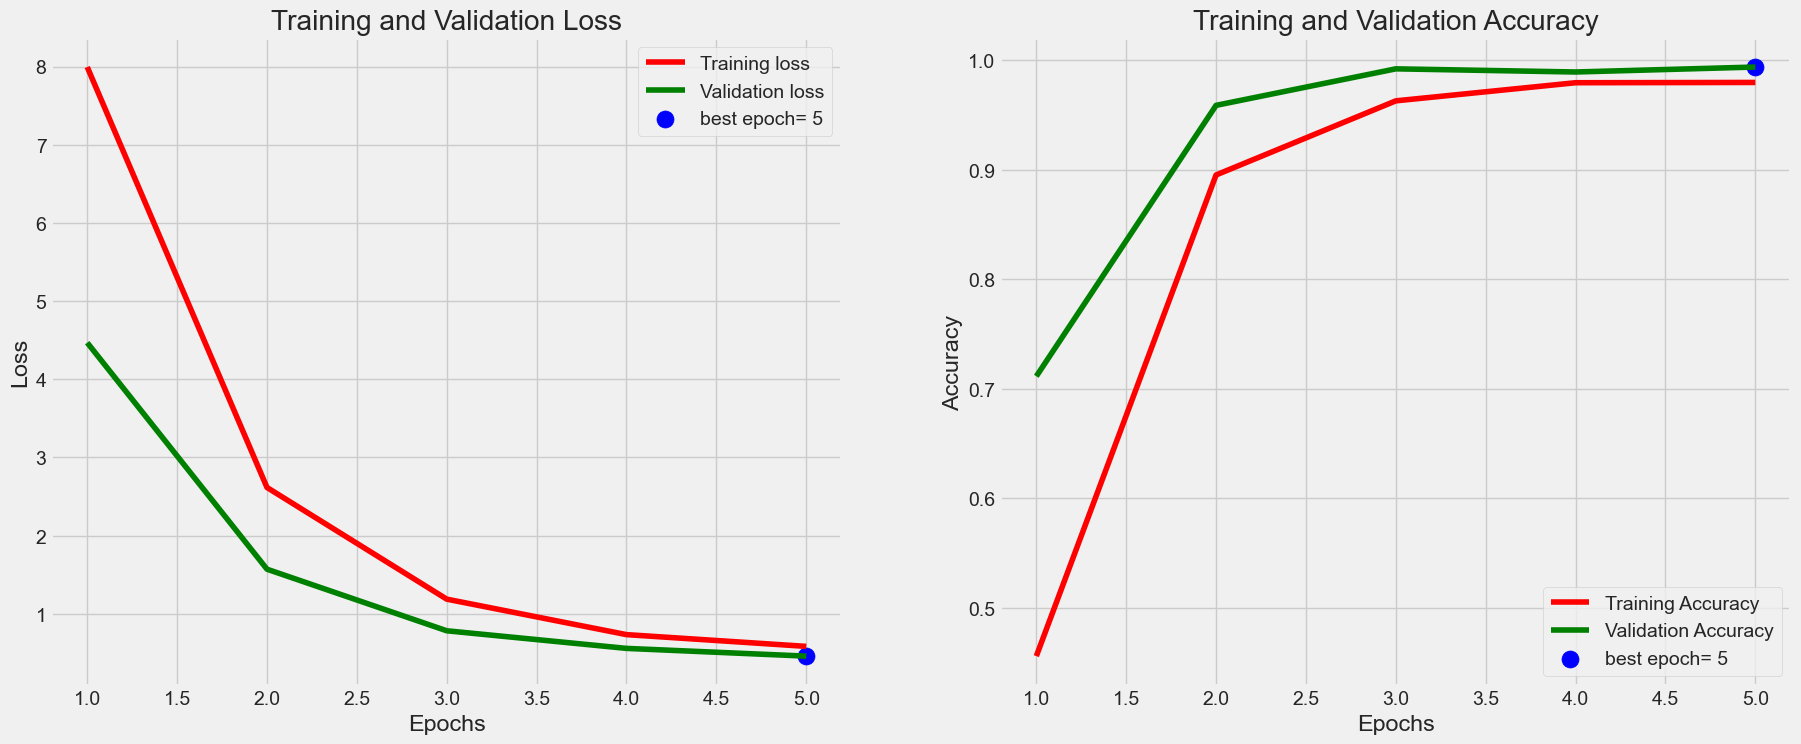

In [13]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

36/36 [==============================] - 135s 4s/step
there were 14 errors in 2700 tests for an accuracy of  99.48


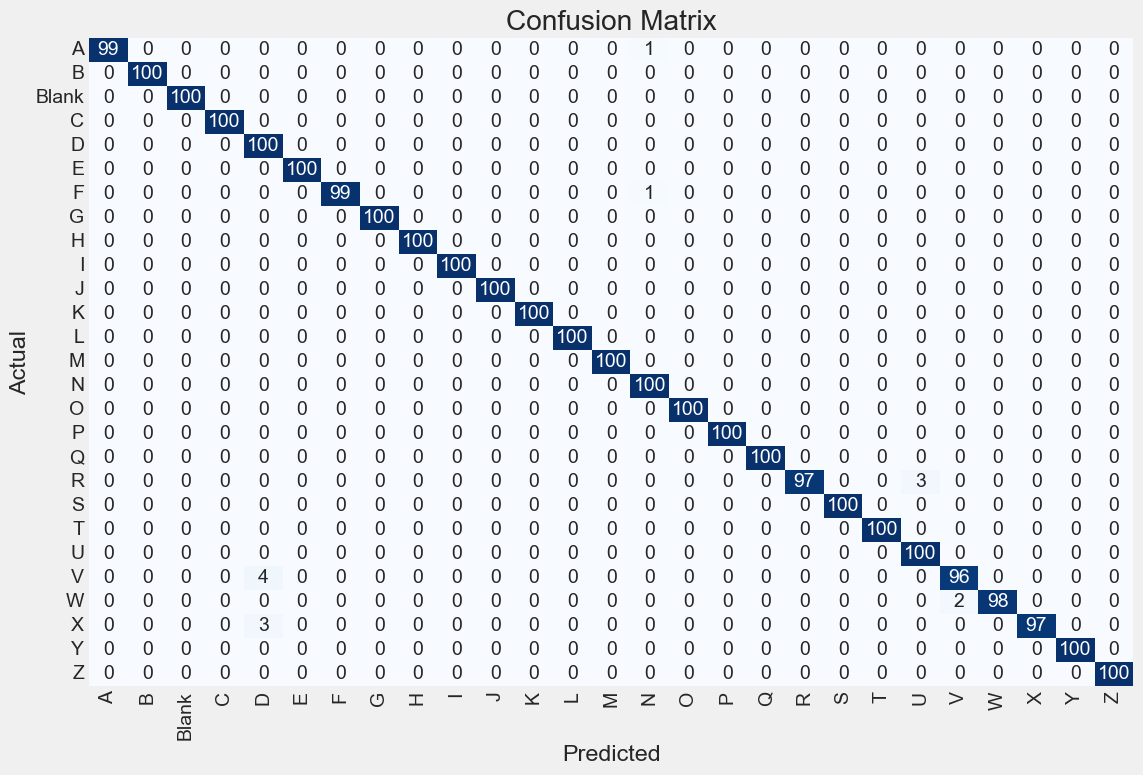

Classification Report:
----------------------
               precision    recall  f1-score   support

           A     1.0000    0.9900    0.9950       100
           B     1.0000    1.0000    1.0000       100
       Blank     1.0000    1.0000    1.0000       100
           C     1.0000    1.0000    1.0000       100
           D     0.9346    1.0000    0.9662       100
           E     1.0000    1.0000    1.0000       100
           F     1.0000    0.9900    0.9950       100
           G     1.0000    1.0000    1.0000       100
           H     1.0000    1.0000    1.0000       100
           I     1.0000    1.0000    1.0000       100
           J     1.0000    1.0000    1.0000       100
           K     1.0000    1.0000    1.0000       100
           L     1.0000    1.0000    1.0000       100
           M     1.0000    1.0000    1.0000       100
           N     0.9804    1.0000    0.9901       100
           O     1.0000    1.0000    1.0000       100
           P     1.0000    1.0000 

In [14]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(train_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, steps=test_steps, verbose=1)
    tests=len(preds)
    for i, p in enumerate(preds):
            pred_index=np.argmax(p)         
            true_index=test_gen.labels[i]  # labels are integer values
            if pred_index != true_index: # a misclassification has occurred                                           
                errors=errors + 1
            y_pred.append(pred_index)
    acc=( 1-errors/tests) * 100
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

In [15]:
subject='asl' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '_' + str(acc) + '.h5' 
model_save_loc=os.path.join(working_dir, save_id)
model.save(model_save_loc)
print ('model was saved as ' , model_save_loc )

model was saved as  ./asl_99.48.h5


In [26]:
classesNew = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model = load_model('asl_99.48.h5')

# Resmi yüklenmesi ve ön işleme
img_path = 'c.jpg'
img = image.load_img(img_path, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)

# Tahminlerin alınması
predictions = model.predict(x)

# Get the index of the highest prediction
highest_prediction_index = np.argmax(predictions[0])

# Print the index and corresponding prediction value
print("Highest prediction index:", highest_prediction_index)
print("Highest prediction value:", predictions[0][highest_prediction_index])
print("Predicted: ", classesNew[highest_prediction_index])

1/1 [==============================] - 2s 2s/step
Highest prediction index: 3
Highest prediction value: 0.5968289
Predicted:  C


In [ ]:
# ## new from gpt

# import os
# import tensorflow as tf

# subject = 'asl'
# acc = str((1 - errors/tests) * 100)
# index = acc.rfind('.')
# acc = acc[:index + 3]
# save_id = subject + '_' + str(acc) + '.h5'
# model_save_loc = os.path.join(working_dir, save_id)

# tf.keras.models.save_model(model, model_save_loc)
# print('Model was saved as:', model_save_loc)


In [ ]:
# model.save('asl_99.44.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# import numpy as np

# # Modeli ve ağırlıkları yükleyin
# model = tf.saved_model.load('asl_99.441.h5')
# # model.load_weights('asl_model_weights.h5')

# # Resmi yükleyin ve ön işleme yapın
# img_path = 'test.jpg'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# # x = preprocess_input(x)

# # Tahminleri yapın
# predictions = model.predict(x)